# Monk Dataset

## Biblioteki

In [ ]:
# dependencies
%pip install minisom numpy pandas matplotlib ucimlrepo scikit-learn optuna tensorflow ipywidgets tqdm

In [ ]:
import optuna
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Dataset

### Przypomnienie

Zestaw zawiera 432 przykłady które reprezentują "roboty". Celem trenowania jest przewidzenie czy robot należy do klasy czy nie.

---



Mają one następujące atrybuty: class, $a_1$, $a_2$, $a_3$, $a_4$, $a_5$, $a_6$, id

- **class**

  Binarna informacja czy robot należy do klasy (1) czy nie (0). W zależności od wersji problemu, roboty są przydzielane do klasy na podstawie innych kryteriów:

| Wersja | Kryterium przydziału do  | Liczba losowanych danych | Źle zaklasyfikowane przykłady |
|--------|------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|------------------|
| $M_1$  | $(\text{head shape} = \text{body shape}) \lor (\text{jacket color} = \text{red})$                                                                          | 124                      | brak             |
| $M_2$  | $\text{dokładnie dwa atrybuty} = 1$                                                                                                                        | 169                      | brak             |
| $M_3$  | $(\text{jacket color} = \text{green} \land \text{holding} = \text{sword}) \lor (\text{jacket color} \neq \text{blue} \land \text{body shape} \neq \text{octagon})$ | 122                      | 5%               |
| |<img width="700"/>| | |

- **$a_1 - a_6$**

  Cechy robotów. Wszystkie z nich są kategoriami.

  Liczba wszystkich możliwych kombinacji tych cech jest równa 432, czyli dokładnie tyle ile instancji zawiera zbiór danych.

  <br/>


| Parametr | Opis         | Wartości                                 | Liczba możlwiości |
|----------|--------------|------------------------------------------| -----------|
| a1       | head shape   | round (1), square (2), ocatgon (3)          | 3 |
| a2       | body shape   | round (1), square (2), octagon (3)          | 3 |
| a3       | is smiling   | yes (1),   no (2)                          | 2 |
| a4       | holding      | sword (1), baloon (2), flag (3)             | 3 |
| a5       | jacket color | red (1), yellow (2), green (3), blue (4)     | 4 |
| a6       | has tie      | yes (1), no (2)                            | 2 |

  <br/>
  
- **id**

  Unikatowy numer robota. Pozwala na identyfikację wylosowanych instancji w zbiorach treningowych.


### Oczekiwanie wyniki według UCI

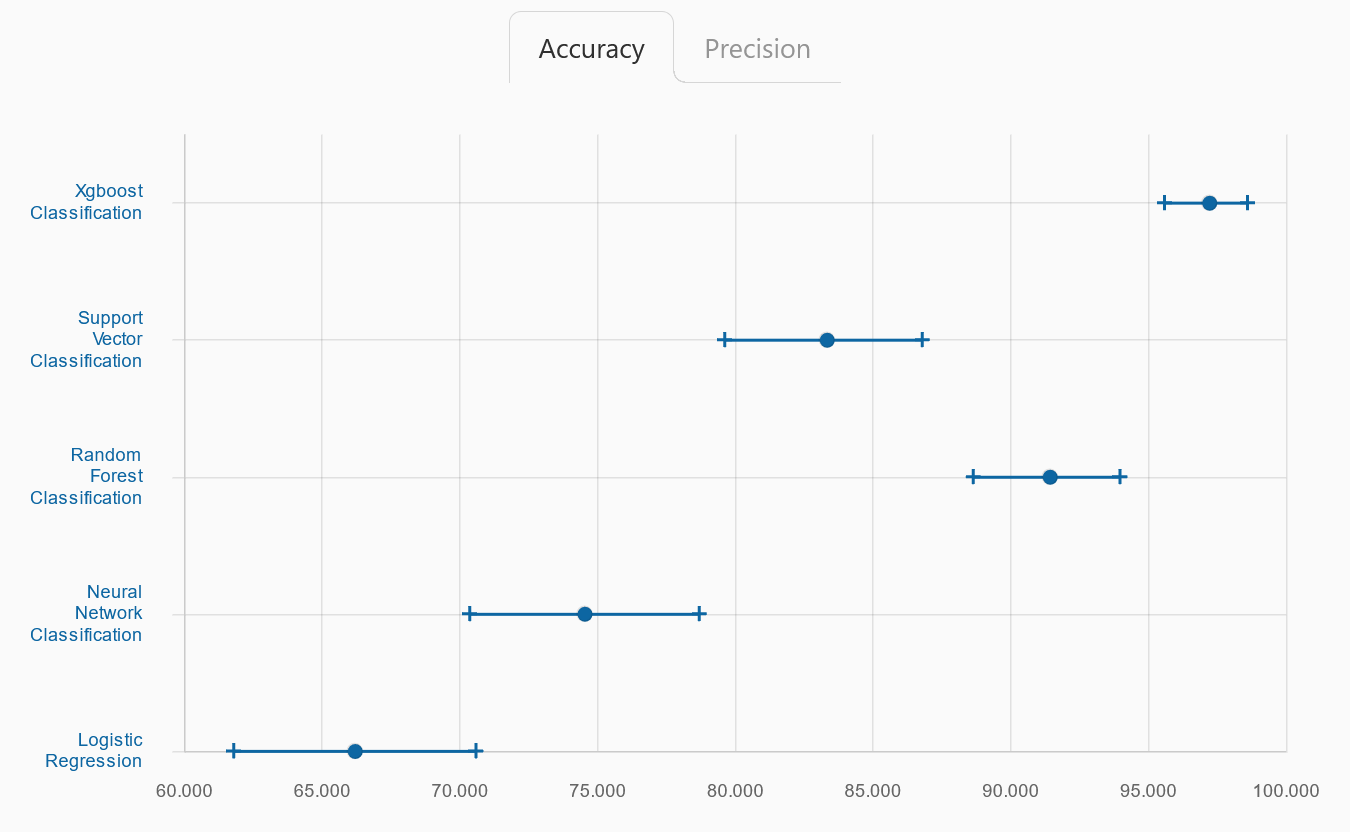

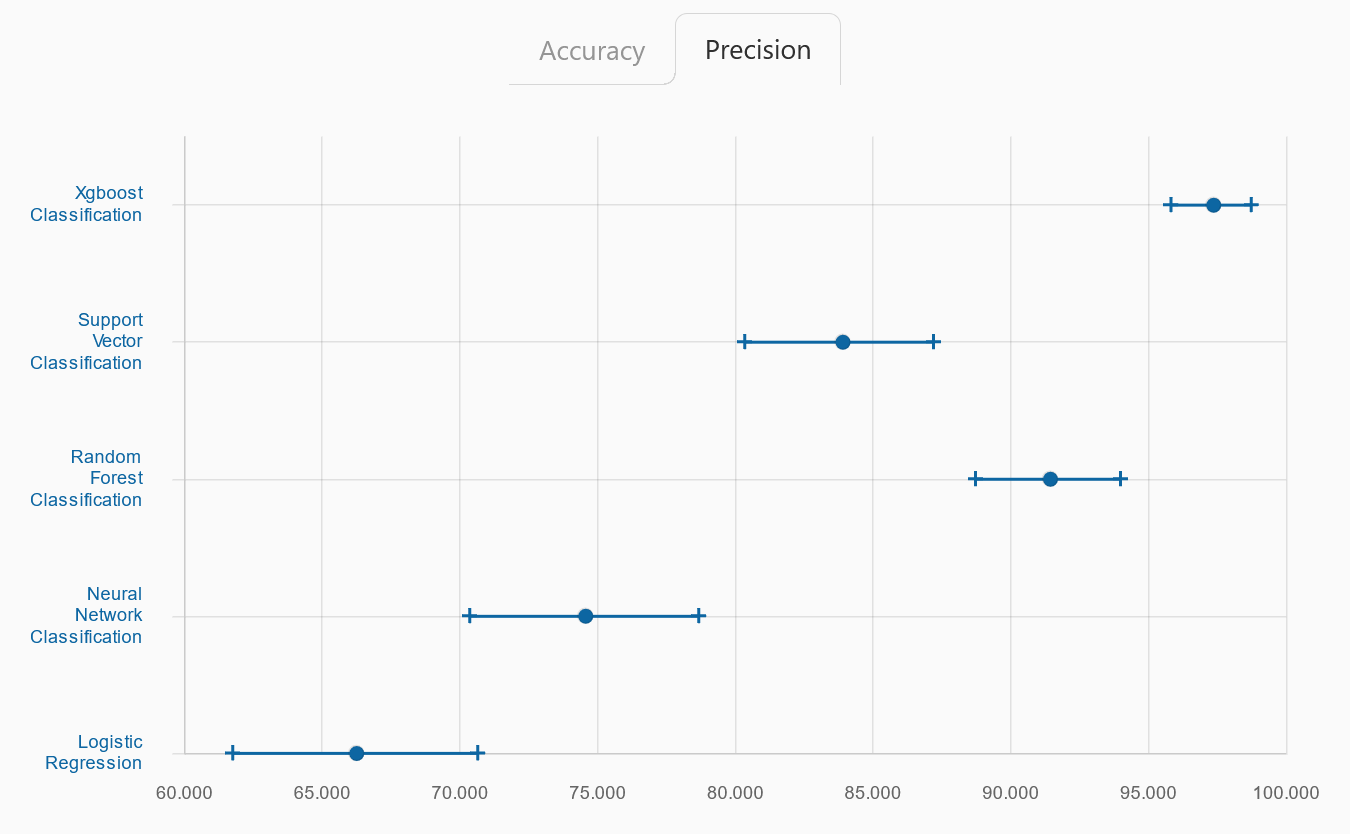

### Przygotowanie danych

In [ ]:
# pobranie zestawu danych

from urllib.request import urlretrieve
import zipfile
import os

ZIP_NAME = 'dataset.zip'

urlretrieve('https://archive.ics.uci.edu/static/public/70/monk+s+problems.zip', ZIP_NAME)

with zipfile.ZipFile(ZIP_NAME, 'r') as archive:
    archive.extractall('monk_dataset')

os.remove(ZIP_NAME)

In [ ]:
# wczytanie datasetów

import pandas as pd
import numpy as np
from sklearn.preprocessing import scale

column_possibilities = np.array([3,3,2,3,4,2])

def read_dataset(path):
  csv = pd.read_csv(path,
                     sep=' ',
                     usecols=range(1,9),
                     names=['target', 'head_shape', 'body_shape', 'is_smiling',
                            'holding', 'jacket_color', 'has_tie', 'label'])

  csv.drop('label', axis=1, inplace=True)
  target = csv.pop('target')

  binary_data = np.zeros((len(csv), np.sum(column_possibilities)), dtype=np.float16)
  for i, row in enumerate(csv.values):
    total = 0
    for j, value in enumerate(row):
      binary_data[i][total + value - 1] = 1
      total += column_possibilities[j]

  return {
      'target': target.values,
      'data': csv.values,
      'binary_data': binary_data,
      'normalized_data': csv.values / column_possibilities
  }


N_DATASETS = 3
test_set = [read_dataset(f"monk_dataset/monks-{i+1}.test") for i in range(N_DATASETS)]
train_set = [read_dataset(f"monk_dataset/monks-{i+1}.train") for i in range(N_DATASETS)]

# Sieć feed forward

### Funkcje pomocnicze

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

tf.keras.config.disable_interactive_logging()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0].name)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

def train_model(train_data, train_target, params):
    '''
    Trenuje i zwraca model o danych parametrach
    '''

    n_neurons = train_data.shape[1]
    regularizer = keras.regularizers.L2(params['weight_decay']) if params['weight_decay'] else None

    model = tf.keras.Sequential([
        keras.layers.Input(shape=(n_neurons,)),
        *[keras.layers.Dense(n_neurons, kernel_regularizer=regularizer, activation='relu') for i in range(params['hidden_layers'])],
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(train_data, train_target, epochs=params['epochs'], batch_size=32, verbose=0)

    return model

No GPU available


In [ ]:
def binary_classification(predictions):
    '''
    Zaokrągla ciągłe predykcje do binarnych klasyfikacji
    '''

    return [1 if x >= 0.5 else 0 for x in predictions]

In [ ]:
import sklearn.metrics as metrics

def get_accuracy(model, test_data, test_target):
    '''
    Oblicza accuracy dla modelu i podanych danych testowych
    '''

    predicted = model.predict(test_data)
    rounded = [1 if x >= 0.5 else 0 for x in predicted] # round zwraca 0 dla 0.5

    return metrics.accuracy_score(test_target, rounded)

In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

def ff_display_results(label, model, test_data, test_target):
    '''
    Wyświetla raporty skuteczności modelu
    '''

    predicted = model.predict(test_data)
    rounded = [1 if x >= 0.5 else 0 for x in predicted] # round zwraca 0 dla 0.5

    print(metrics.classification_report(test_target, rounded, zero_division=0))
    print()

    fpr, tpr, _ = metrics.roc_curve(test_target, predicted)
    auc = metrics.roc_auc_score(test_target, predicted)

    plt.plot(fpr, tpr, label=f"{label} AUC= {auc:.2f}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

### Odtworzenie oryginalnego eksperymentu

Test 1
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       216
           1       0.97      1.00      0.98       216

    accuracy                           0.98       432
   macro avg       0.98      0.98      0.98       432
weighted avg       0.98      0.98      0.98       432


Test 2
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       290
           1       0.94      0.96      0.95       142

    accuracy                           0.97       432
   macro avg       0.96      0.97      0.96       432
weighted avg       0.97      0.97      0.97       432


Test 3
              precision    recall  f1-score   support

           0       0.91      1.00      0.96       204
           1       1.00      0.92      0.96       228

    accuracy                           0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       4

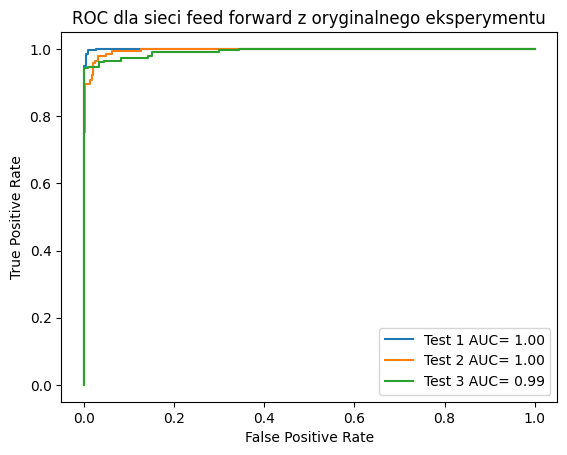

In [ ]:
params = [
    {'epochs': 390, 'hidden_layers': 3, 'weight_decay': None},
    {'epochs': 90, 'hidden_layers': 2, 'weight_decay': None},
    {'epochs': 105, 'hidden_layers': 4, 'weight_decay': 0.01}
]

plt.title('ROC dla sieci feed forward z oryginalnego eksperymentu')
for i, p in enumerate(params):
    keras.utils.set_random_seed(222)

    test_label = f'Test {i+1}'
    print(test_label)

    model = train_model(train_set[i]['binary_data'], train_set[i]['target'], p)
    ff_display_results(test_label, model, test_set[i]['binary_data'], test_set[i]['target'])

#### Wyniki według oryginalnego eksperymentu

| nr. problemu | accuracy | accuracy oryginalnego eksperymentu |
|--------------|----------|------------------------------------|
| 1            | 98%      | 100%                               |
| 2            | 97%      | 100%                               |
| 3            | 96%      | 97.2%                              |

#### Wnioski

Wyniki nie są identyczne z oryginalnymi, choć wciąż oferują bardzo dobrą jakość klasyfikacji.
Na różnice może wpływać losowość inicjalizacji wag w sieciach neuronowych, a także niesprecyzowanie dokładnych parametrów eksperymentu. Nie znajdziemy tam na przykład informacji, na temat funkcji aktywacji.

Zdecydowanie można też stwierdzić, że porponowane prez UCI wyniki są stanowczo zaniżone.

### Próba poprawy wyników

Dla pierwszych dwóch problemów dostosowanie parametrów nie jest skomplikowane. Zwykłe zmiany na oślep wystarczą aby osiągnąć wyniki idealne.

Test 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432


Test 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      0.99      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432




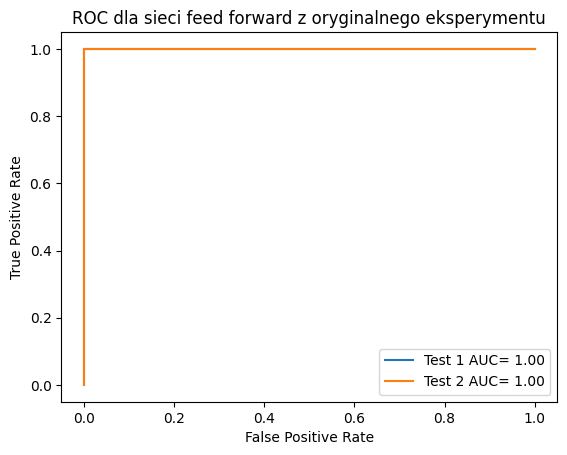

In [ ]:
params = [
    {'epochs': 200, 'hidden_layers': 2, 'weight_decay': None},
    {'epochs': 150, 'hidden_layers': 2, 'weight_decay': None},
]

plt.title('ROC dla sieci feed forward z oryginalnego eksperymentu')
for i, p in enumerate(params):
    keras.utils.set_random_seed(222)

    test_label = f'Test {i+1}'
    print(test_label)

    model = train_model(train_set[i]['binary_data'], train_set[i]['target'], p)
    ff_display_results(test_label, model, test_set[i]['binary_data'], test_set[i]['target'])

Dla problemu 3 natomiast skorzystam z biblioteki `optuna` aby znaleźć optymalne parametry.

In [ ]:
import optuna

TEST_N = 2

def optimize_ff(trial):
    '''
    Oblicza skuteczność modelu dla danej próby
    '''

    params = {
        'epochs': trial.suggest_int('epochs', 90, 300),
        'hidden_layers': trial.suggest_int('hidden_layers', 2, 4),
        'weight_decay': trial.suggest_float('weight_decay', 0, 0.5)
    }

    keras.utils.set_random_seed(222)

    model = train_model(train_set[TEST_N]['binary_data'], train_set[TEST_N]['target'], params)
    return get_accuracy(model, test_set[TEST_N]['binary_data'], test_set[TEST_N]['target'])

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(optimize_ff, n_trials=50, show_progress_bar=True)

print('Wyliczone parametry:', study.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

Wyliczone parametry: {'epochs': 233, 'hidden_layers': 3, 'weight_decay': 0.06730032892179622}


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432




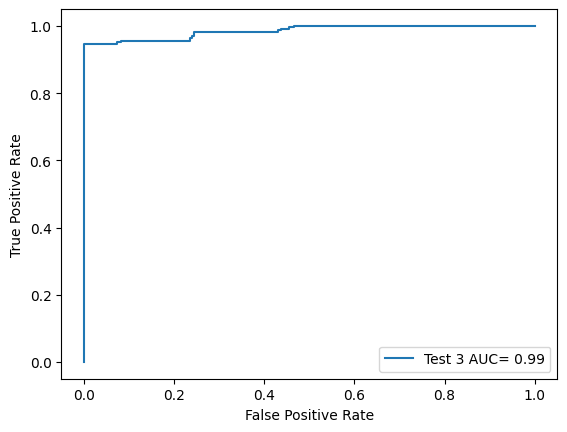

In [ ]:
keras.utils.set_random_seed(222)

model = train_model(train_set[TEST_N]['binary_data'], train_set[TEST_N]['target'], study.best_params)
ff_display_results('Test 3', model, test_set[TEST_N]['binary_data'], test_set[TEST_N]['target'])

#### Wniosek

Rzeczywiście ciężkie jest przebicie wyników z oryginalnego eksperymentu.

# SOM

Sieć SOM może nie być najlepszym wyborem dla tego problemu, biorąc pod uwagę że dane zawierają wyłącznie dane kategoryczne. Same kategorie niczym się od siebie nie różnią, więc znalezienie zależności powinno być ciężkie.

### Funkcje pomocnicze

In [ ]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import metrics

class MonkSOM:
    SEED = 222
    labels = ['nie', 'tak']

    def __init__(self, train_data, train_target, size, **params):
        '''
        Trenuje model
        '''

        self.size = size
        self.params = params
        self.train_data = train_data
        self.train_target = train_target
        self.som = MiniSom(size, size, train_data.shape[1], random_seed=MonkSOM.SEED, **params)

        self.som.pca_weights_init(train_data)
        self.som.train(train_data, 500, verbose=False)

        self.label_map = self.som.labels_map(train_data, train_target)
        self.percentage_map = {}
        for position in self.label_map:
            self.percentage_map[position] = self.label_map[position][1] / sum(self.label_map[position].values())

    def classify(self, data):
        '''
        Klasyfikuje dane jako prawdopodobieństwo należenia do klasy
        '''

        default_class = 0
        result = []
        for d in data:
            win_position = self.som.winner(d)
            if win_position in self.percentage_map:
                result.append(self.percentage_map[win_position])
            else:
                result.append(default_class)

        return np.array(result)

    def classify_binary(self, data):
        '''
        Klasyfikuje dane jako binarny wynik - 0 lub 1
        '''

        return np.round(self.classify(data))

    def get_accuracy(self, test_data, test_target):
        '''
        Oblicza accuracy dla danych testowych
        '''

        predicted = self.classify_binary(test_data)
        return metrics.accuracy_score(test_target, predicted)

    def display_efficacy(self, test_data, test_target):
        '''
        Wyświetla raporty skuteczności modelu
        '''

        predicted = self.classify(test_data)
        rounded = np.round(predicted)

        print(metrics.classification_report(test_target, rounded, zero_division=0))
        print()

        fpr, tpr, _ = metrics.roc_curve(test_target, predicted)
        auc = metrics.roc_auc_score(test_target, predicted)

        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, label=f"AUC= {auc:.2f}")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)

    def display_net(self):
        '''
        Wyświetla wykres przynależności neuronów do klas, a także gdzie oryginalne dane wpadają do siatki
        '''

        w_x, w_y = zip(*[self.som.winner(d) for d in self.train_data])
        w_x = np.array(w_x)
        w_y = np.array(w_y)

        plt.figure(figsize=(9, 9))
        plt.title('Lokalizacja danych w sieci')
        plt.pcolor(self.som.distance_map().T, cmap='bone_r', alpha=.2)
        plt.colorbar()

        for c in np.unique(self.train_target):
          idx_target = self.train_target==c
          plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                      w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                      s=50, label=self.labels[c])

        plt.legend(loc='upper right')
        plt.grid()
        plt.show()

        plt.figure(figsize=(9, 9))
        plt.title('Klasyfikacja neuronów')
        grid = gridspec.GridSpec(self.size, self.size)
        for position in self.label_map:
            label_fracs = [self.label_map[position][l] for l in range(2)]
            plt.subplot(grid[self.size-1-position[1], position[0]])
            patches, texts = plt.pie(label_fracs, shadow=True, startangle=90)

        plt.legend(patches, self.labels, bbox_to_anchor=(3, 6), ncol=2)
        plt.show()


### Szukanie parametrów

W tym przypadku nie ma żadnej podpowiedzi dotyczącej oczekiwanych parametrów. Konieczne jest eksperymentowanie. Ponownie wykorzystam do tego celu bibliotekę `optuna`

In [ ]:
import optuna

def generate_params(trial):
    '''
    Generuje zestaw parametrów dla danej próby
    '''

    params = {
        'size': trial.suggest_int('size', 6, 12),
        'sigma': trial.suggest_float('sigma', 0.1, 5.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 5.0),
        'neighborhood_function': trial.suggest_categorical('neighborhood_function', ['gaussian', 'mexican_hat', 'bubble', 'triangle'])
    }

    return params

def optimize_single(i, trial):
    '''
    Oblicza skuteczność modelu dla danej próby
    '''

    params = generate_params(trial)
    som = MonkSOM(train_set[i]['data'], train_set[i]['target'], **params)

    return som.get_accuracy(test_set[i]['data'], test_set[i]['target'])

def find_one(i):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: optimize_single(0, trial), n_trials=1_000, show_progress_bar=True)
    print(f'znalezione parametry dla problemu {i+1}: ', study.best_params)

    return study.best_params

def graph_som(i, params):
    som1 = MonkSOM(train_set[i]['data'], train_set[i]['target'], **params)

    som1.display_efficacy(test_set[i]['data'], test_set[i]['target'])
    plt.show()

    som1.display_net()
    plt.show()

### Zestaw 1

In [ ]:
problem1 = find_one(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

znalezione parametry dla problemu 1:  {'size': 11, 'sigma': 0.9895802458638614, 'learning_rate': 2.7022510236040334, 'neighborhood_function': 'gaussian'}


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       216
           1       0.86      0.84      0.85       216

    accuracy                           0.85       432
   macro avg       0.85      0.85      0.85       432
weighted avg       0.85      0.85      0.85       432




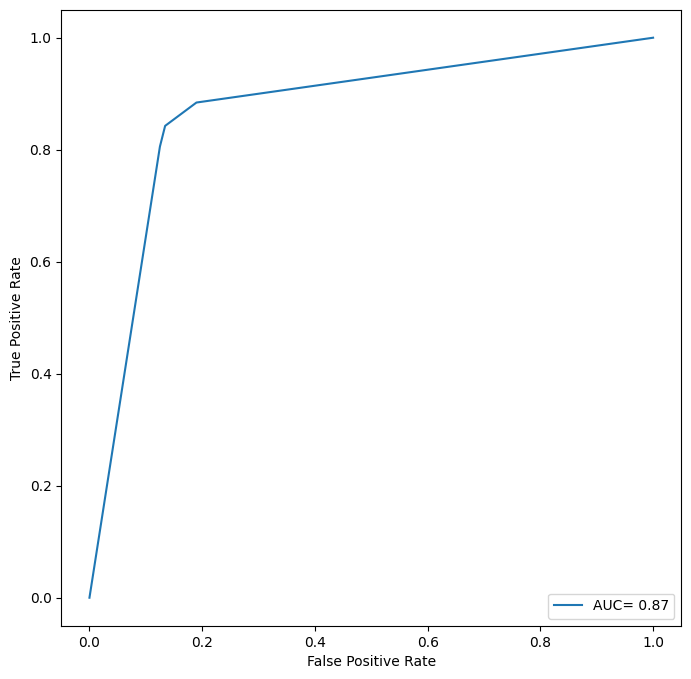

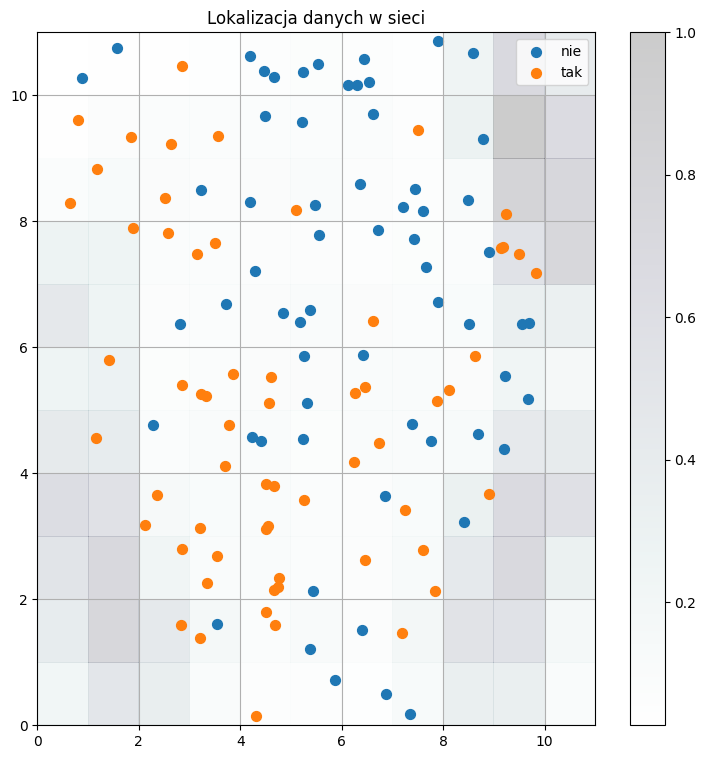

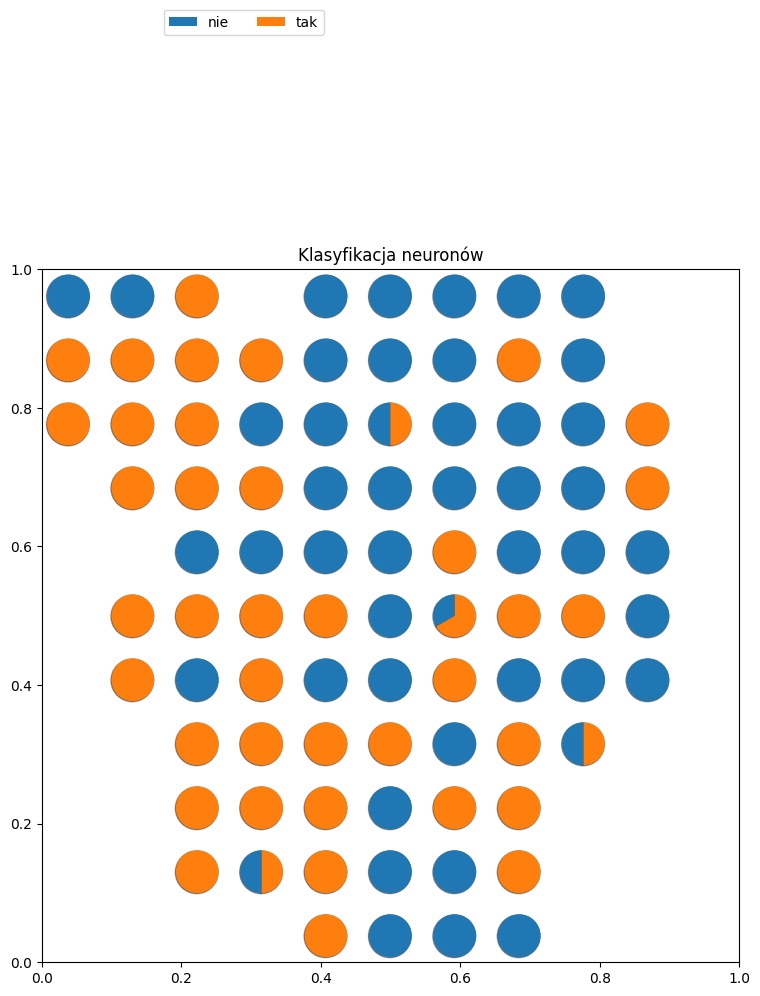

In [ ]:
graph_som(0, problem1)

### Zestaw 2

In [ ]:
# Wariant tylko dla problemu nr. 2

problem2 = find_one(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

znalezione parametry dla problemu 2:  {'size': 12, 'sigma': 1.1891609414338502, 'learning_rate': 2.8397346981223164, 'neighborhood_function': 'gaussian'}


              precision    recall  f1-score   support

           0       0.77      0.83      0.80       290
           1       0.59      0.48      0.53       142

    accuracy                           0.72       432
   macro avg       0.68      0.66      0.66       432
weighted avg       0.71      0.72      0.71       432




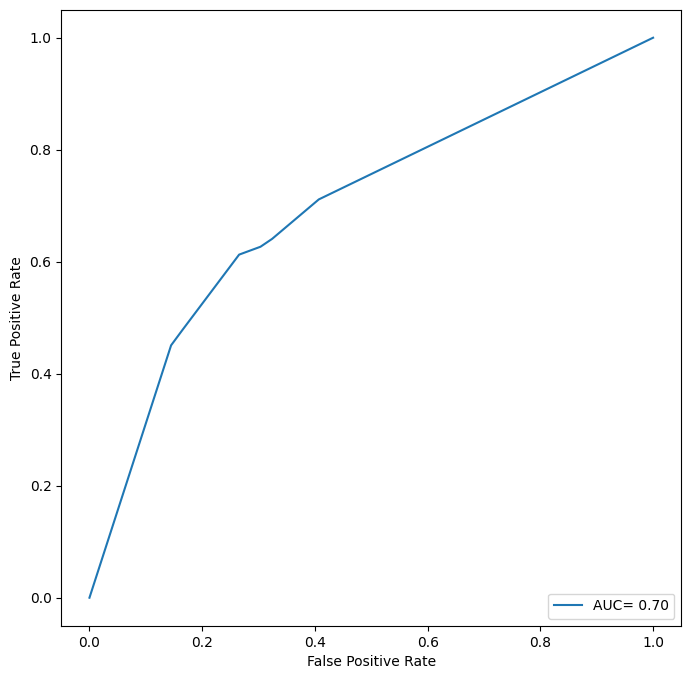

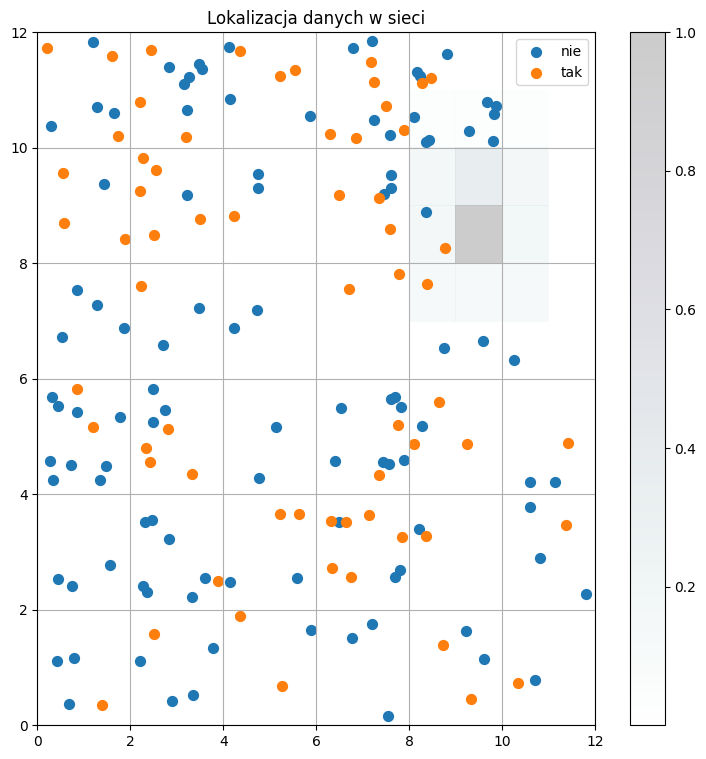

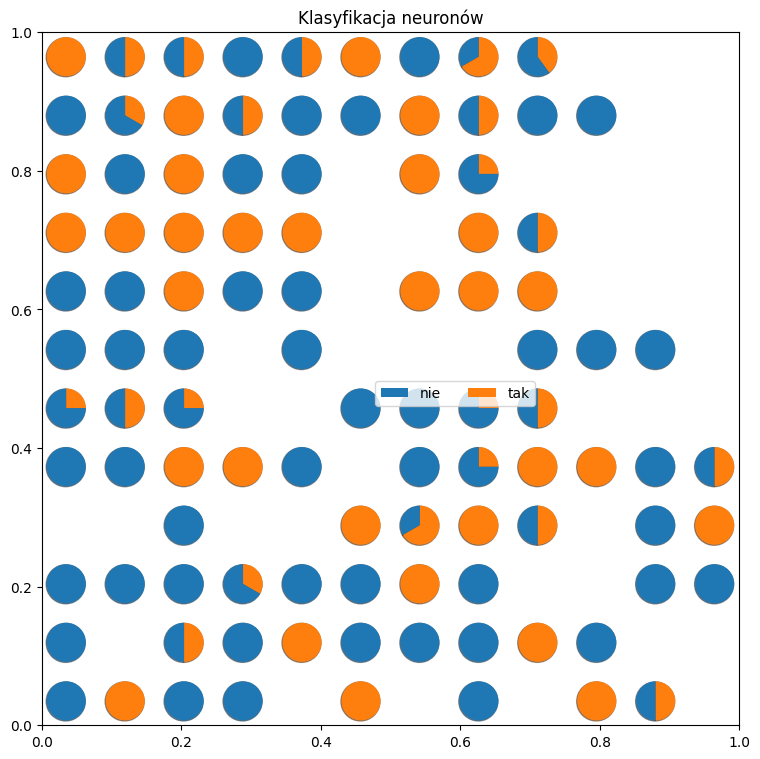

In [ ]:
graph_som(1, problem2)

### Zestaw 3

In [ ]:
# Wariant tylko dla problemu nr. 3
problem3 = find_one(2)

  0%|          | 0/1000 [00:00<?, ?it/s]

znalezione parametry dla problemu 3:  {'size': 12, 'sigma': 3.047626402668022, 'learning_rate': 0.17360715170865237, 'neighborhood_function': 'triangle'}


              precision    recall  f1-score   support

           0       0.75      0.92      0.82       204
           1       0.91      0.72      0.80       228

    accuracy                           0.81       432
   macro avg       0.83      0.82      0.81       432
weighted avg       0.83      0.81      0.81       432




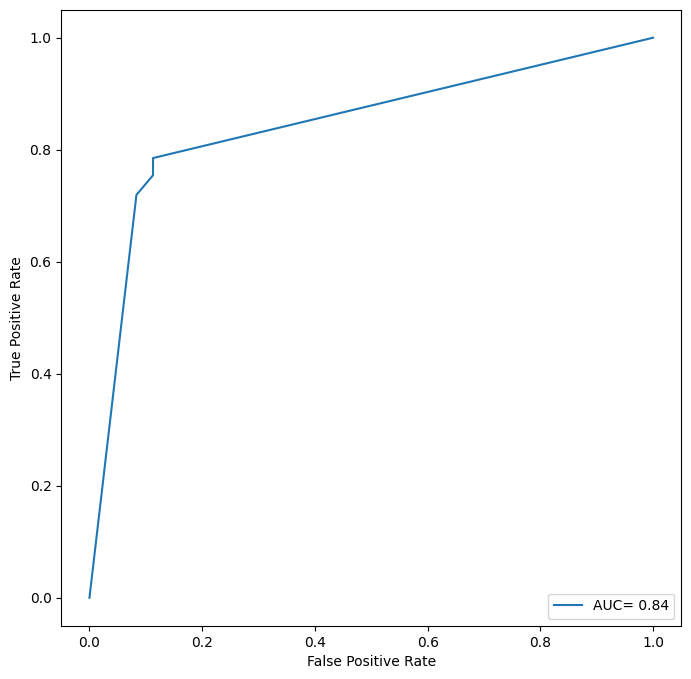

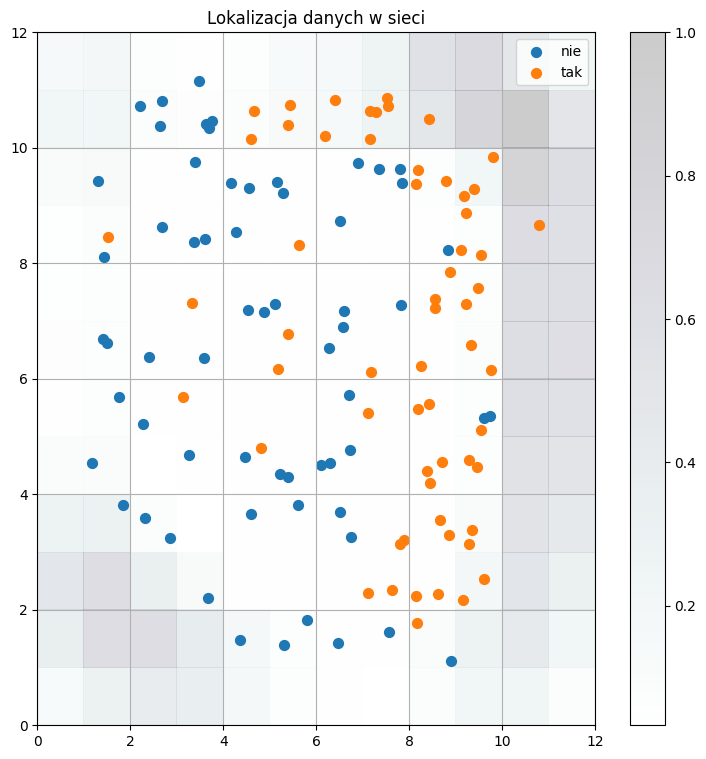

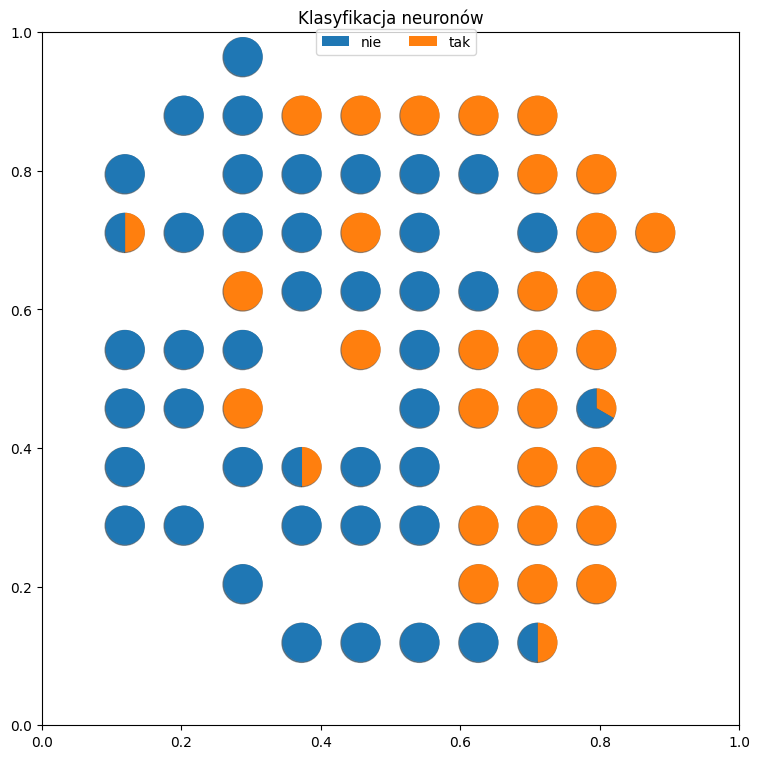

In [ ]:
graph_som(2, problem3)

### Wnioski

Pomimo dość cięzkiego zdania, udaje się sieci som zauważyć zależności między danymi.